# Modelo de Fatores Dinâmicos (DFM) - 1 fator: PCA + OLS estimation
---

> Modelo inicial, análise de resíduos, de sazonalidade, resultados iniciais e expansão do modelo com defasagens.

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import jarque_bera

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan


In [2]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [3]:
pio.renderers.default = 'browser'

## Funções

In [4]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RMSE = np.sqrt(mean_squared_error(Y,model_k.predict(X)))
    R_squared = model_k.score(X,Y)
    return RMSE, R_squared

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y.dropna(), regression = 'n', autolag = 'BIC')[1]
        ts_ax.set_title('ADF1 test: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
# CRIANDO LAGS 

def create_lags(df, lags):
    for col in df.columns:
        for lag in lags:
            df.loc[:,col+"_"+str(lag)] = df[col].shift(lag)

In [7]:
def stepwise_selection(X, y, 
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

# Dados

In [8]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_full_tf12.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tf_fullpca12.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

# data_pca = data_pca[['F1']]

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
# new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data.dropna(axis = 0, inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2003-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

C:\Users\Henri\AppData\Local\Temp\ipykernel_18520\3364649565.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.



,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9
2003-03-01,2.666546,0.251840,4.644614,-2.343996,-4.839266,-1.098580,-0.200759,-0.412446,0.038634,1.258694
2003-06-01,0.779828,-1.696903,0.509569,0.222964,-2.698887,-2.546184,0.716978,-1.207633,-0.771692,-0.933105
2003-09-01,0.627615,-1.601460,-2.426276,1.907003,0.638982,-1.768961,-0.268672,0.026990,-0.413791,-2.117863
2003-12-01,0.587051,-0.679959,-6.912019,5.116493,5.817184,-1.332162,-0.807454,1.501090,-0.082572,-2.015586
2004-03-01,3.873921,1.802712,-3.463629,2.219726,5.152578,0.541123,-0.230916,1.496303,-0.867851,-0.109071
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,4.430455,3.738379,0.534838,3.964202,-8.997468,-6.446538,-2.632331,1.872125,-1.556724,-4.277536
2021-12-01,2.135107,-2.906755,-1.536199,4.094167,-5.389050,-5.303151,0.298032,1.951486,-3.269461,-2.835331
2022-03-01,2.428437,-1.695208,-1.326960,0.819037,-6.982580,-3.447312,0.678199,-1.335356,-0.609842,2.345623
2022-06-01,3.686851,0.449515,-1.562306,3.847391,-6.624737,-1.884091,-0.833586,0.663407,-1.859994,1.821333


In [9]:
# Criando defasagens dos fatores e do PIB

lags = [1, 2, 3, 4]
create_lags(new_data, lags)
new_data.dropna(inplace=True)
new_data.head(12)

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F7_3,F7_4,F8_1,F8_2,F8_3,F8_4,F9_1,F9_2,F9_3,F9_4
2004-03-01,3.873921,1.802712,-3.463629,2.219726,5.152578,0.541123,-0.230916,1.496303,-0.867851,-0.109071,...,-1.207633,-0.412446,-0.082572,-0.413791,-0.771692,0.038634,-2.015586,-2.117863,-0.933105,1.258694
2004-06-01,6.310721,4.530637,0.623758,-0.528949,2.179152,2.099742,-1.540273,2.365094,-0.173012,2.272560,...,0.026990,-1.207633,-0.867851,-0.082572,-0.413791,-0.771692,-0.109071,-2.015586,-2.117863,-0.933105
2004-09-01,6.561331,5.953827,0.802781,-0.242507,0.312473,0.755377,-1.401724,1.929078,-1.053574,1.513991,...,1.501090,0.026990,-0.173012,-0.867851,-0.082572,-0.413791,2.272560,-0.109071,-2.015586,-2.117863
2004-12-01,6.211439,3.640430,-0.034575,-0.231934,-0.687491,0.989720,-0.570688,1.032215,-1.246268,-0.170592,...,1.496303,1.501090,-1.053574,-0.173012,-0.867851,-0.082572,1.513991,2.272560,-0.109071,-2.015586
2005-03-01,4.187150,0.739175,-1.216670,0.543227,-0.762425,0.439684,-0.617884,0.948362,0.423280,-0.319503,...,2.365094,1.496303,-1.246268,-1.053574,-0.173012,-0.867851,-0.170592,1.513991,2.272560,-0.109071
2005-06-01,4.472301,1.279240,-3.173227,1.278544,-0.600555,0.614876,0.298848,-0.342630,-0.320949,-0.538778,...,1.929078,2.365094,0.423280,-1.246268,-1.053574,-0.173012,-0.319503,-0.170592,1.513991,2.272560
2005-09-01,2.114874,-1.203882,-4.761767,1.301032,1.441375,1.236339,-0.577891,-0.239112,1.319184,-1.126659,...,1.032215,1.929078,-0.320949,0.423280,-1.246268,-1.053574,-0.538778,-0.319503,-0.170592,1.513991
2005-12-01,2.150875,-1.034920,-2.150437,0.439321,1.608814,1.803903,-0.903089,-0.717267,1.748431,0.838978,...,0.948362,1.032215,1.319184,-0.320949,0.423280,-1.246268,-1.126659,-0.538778,-0.319503,-0.170592
2006-03-01,4.279206,0.628408,-3.046015,-0.008475,2.214782,0.860204,-1.066485,-0.253635,0.617619,0.510935,...,-0.342630,0.948362,1.748431,1.319184,-0.320949,0.423280,0.838978,-1.126659,-0.538778,-0.319503
2006-06-01,2.283635,-0.308110,-1.604163,0.158446,3.963350,0.812203,-2.332522,0.623232,1.518920,0.130227,...,-0.239112,-0.342630,0.617619,1.748431,1.319184,-0.320949,0.510935,0.838978,-1.126659,-0.538778


In [10]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# X e y completos

X = new_data.drop('gdp', axis = 1)
y = new_data.gdp

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Modelo: Lasso + DFM com dinâmica
---

## LASSO: seleção de variáveis

In [11]:
# GRID 1

tscv = TimeSeriesSplit(n_splits=5)
lassocv = Lasso()
alphas =  np.arange(0, 1, 0.001)
parameters = [{'alpha':alphas}]
lasso_regressor = GridSearchCV(lassocv, parameters,scoring='neg_root_mean_squared_error',cv=tscv, error_score='raise', n_jobs=-1) 
lasso_regressor.fit(X_train,y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.34900000000000003}
-1.1436028424546367


In [12]:
lasso = Lasso(alpha = 0.35, fit_intercept = True)
lasso.fit(X_train, y_train)
selected_lasso = pd.DataFrame({'coefs':lasso.coef_, 'variables':lasso.feature_names_in_})
selected_lasso['coefs'] = selected_lasso['coefs'].abs()
selected_lasso.query('coefs > 0').count()

coefs        9
variables    9
dtype: int64

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6')])

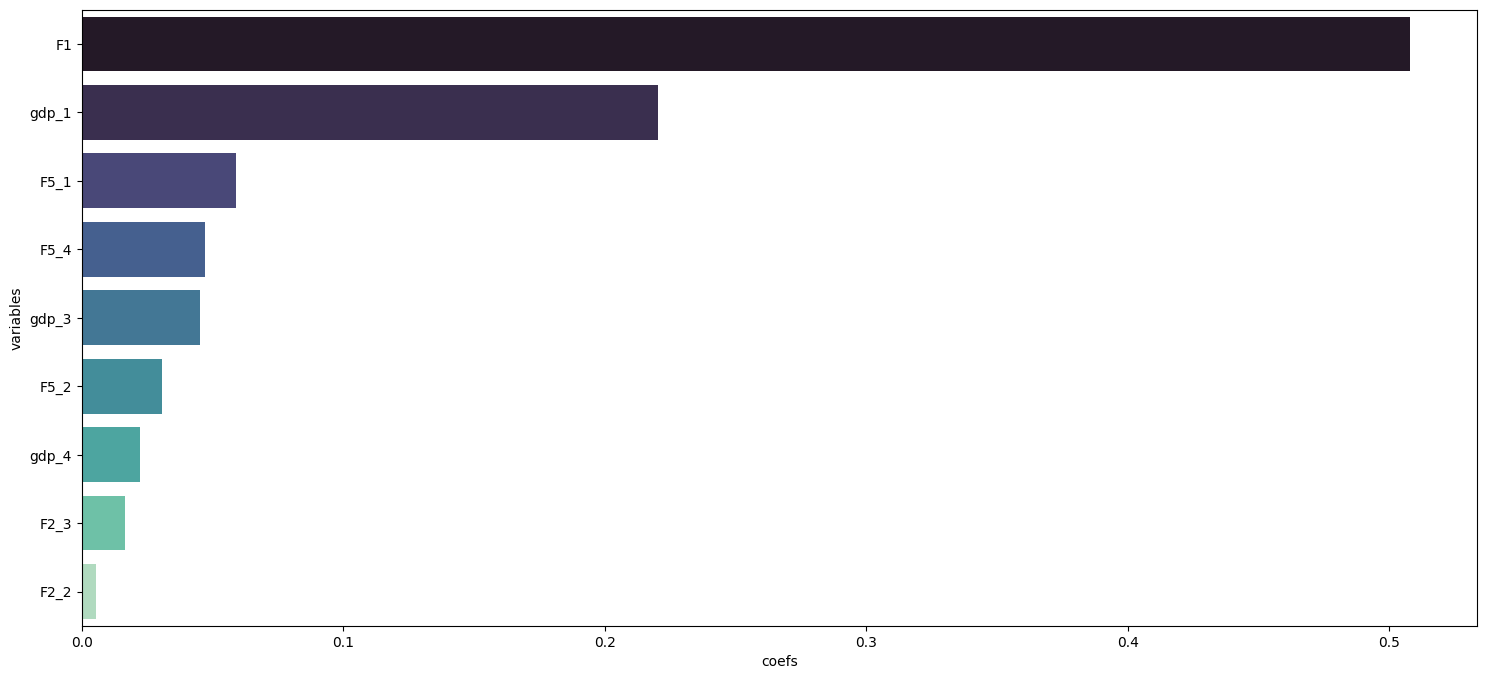

In [13]:
selected_lasso = selected_lasso.query('coefs > 0')
selected_lasso = selected_lasso.sort_values(by = 'coefs', ascending = False)
plt.figure(figsize=(18,8))
sns.barplot(x = 'coefs', y = 'variables', data = selected_lasso, palette = 'mako')
plt.xticks(rotation = 0)
# plt.savefig('DFM-PLOTS-GTC/DFM5GTC-selected-vars.png')

## Performance

### Previsões

<AxesSubplot: >

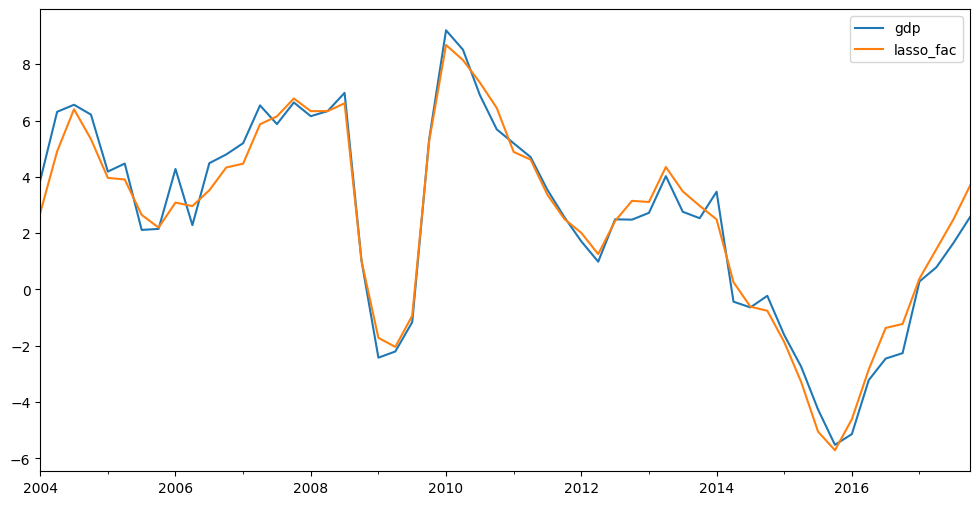

In [14]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train.loc['2004Q1':]
forecasts_insample['lasso_fac'] = lasso.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

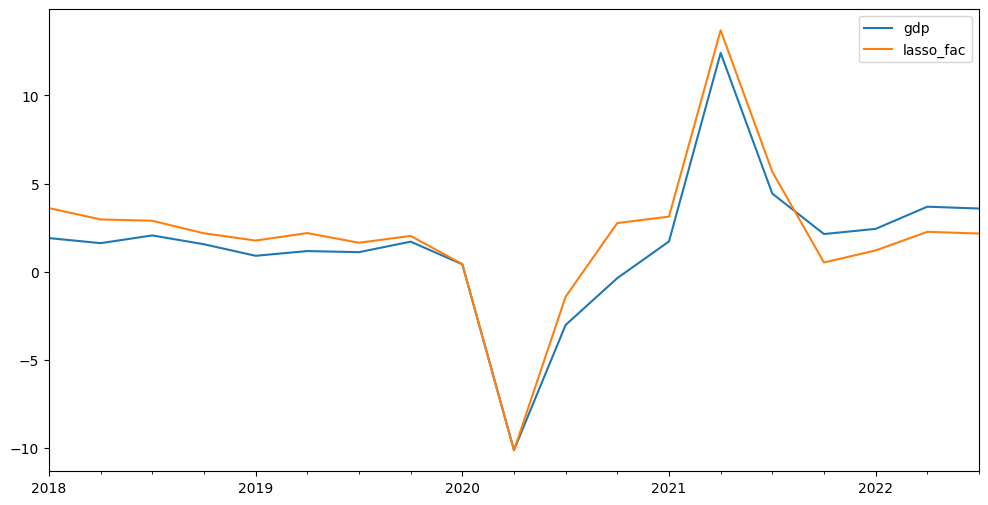

In [15]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['lasso_fac'] = lasso.predict(X_test)
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD, MAPE

In [16]:
# Métricas IN-SAMPLE - LASSO FACTORS

forecasts_insample = forecasts_insample.dropna(axis = 0)
rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['lasso_fac']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['lasso_fac'].dropna())
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['lasso_fac'].dropna())
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

0.6024229635773963

0.4899998125604106

0.2307161293717608


In [17]:
# Métricas OUT-OF-SAMPLE - LASSO FACTORS

rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['lasso_fac']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['lasso_fac'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['lasso_fac'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

1.330548614064586

1.1378477694469005

0.9150854223770993


# Análise dos resíduos

## Autocorrelação

c:\Users\Henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



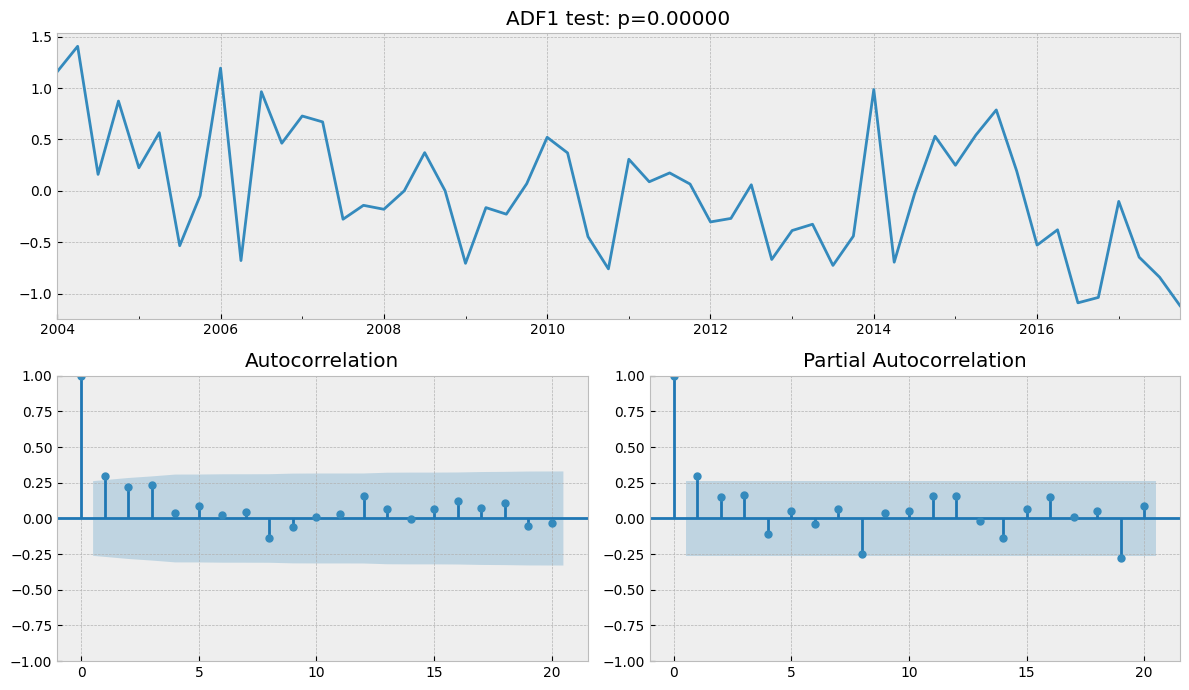

In [18]:
# Plotando a função de autocorrelação
resid = (forecasts_insample['gdp'] - forecasts_insample['lasso_fac'])
tsplot(resid, lags = 20)
# plt.savefig('DFM-PLOTS-GTC/DFM5GTC-resids-insamp.png')

In [19]:
# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(resid, lags = 20)

# Resultados

print(round(lb_result, 4))

    lb_stat  lb_pvalue
1    5.1409     0.0234
2    7.9827     0.0185
3   11.4535     0.0095
4   11.5310     0.0212
5   12.0143     0.0346
6   12.0611     0.0606
7   12.1991     0.0942
8   13.4545     0.0971
9   13.6920     0.1337
10  13.6969     0.1873
11  13.7594     0.2466
12  15.5658     0.2119
13  15.8923     0.2550
14  15.8923     0.3200
15  16.2115     0.3681
16  17.3898     0.3608
17  17.8667     0.3973
18  18.8305     0.4023
19  19.0942     0.4508
20  19.2010     0.5088


## Normalidade

C:\Users\Henri\AppData\Local\Temp\ipykernel_18520\1493935616.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<AxesSubplot: ylabel='Density'>

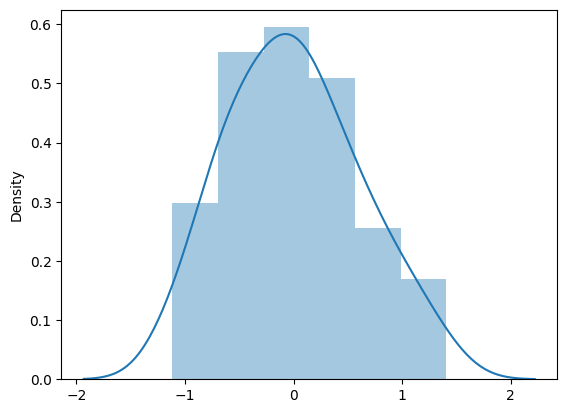

In [20]:
sns.distplot(resid, kde=True, hist=True)
# plt.savefig('DFM-PLOTS-GTC/DFM5GTC-normality-resids-insamp.png')

In [21]:
# TESTE DE JARQUE-BERA

jb = jarque_bera(resid)
print('JB test stat:', round(jb[0], 3), sep = ' ')
print('p-value:', round(jb[1], 3), sep = ' ')
print('Skewness:', round(jb[2], 3), sep = ' ')
print('Kurtosis:', round(jb[3], 3), sep = ' ')

JB test stat: 1.342
p-value: 0.511
Skewness: 0.257
Kurtosis: 2.443
